In [1]:
import numpy as np
import scipy
import enum
import matplotlib.pyplot as plt
from time import time
from xclib.data import data_utils

### Loading the data

In [2]:
# Train data
x_train = data_utils.read_sparse_file('./ass3_parta_data/train_x.txt').toarray()
y_train = np.loadtxt('./ass3_parta_data/train_y.txt', dtype=int)

# Test data
x_test = data_utils.read_sparse_file('./ass3_parta_data/test_x.txt').toarray()
y_test = np.loadtxt('./ass3_parta_data/test_y.txt', dtype=int)

# Validation data
x_val = data_utils.read_sparse_file('./ass3_parta_data/valid_x.txt').toarray()
y_val = np.loadtxt('./ass3_parta_data/valid_y.txt', dtype=int)

/Users/dronemist/.local/lib/python3.6/site-packages/xclib-0.96-py3.6-macosx-10.9-x86_64.egg/xclib/data/data_utils.py:173: UserWarning: Header mis-match from inferred shape!
  warnings.warn("Header mis-match from inferred shape!")


### Part A

In [3]:
class NodeType(enum.Enum):
    Leaf = 1
    Node = 2

In [4]:
# Node for the decision tree
class Node:
    
    # Constructor for node    
    def __init__(self, index, value, node_type = NodeType.Node, data = -1):
        self.left = None
        self.right = None
        self.attribute_index = index
        self.value = value
        self.type = node_type
        self.data = data
    
    # Convert the node to a leaf node    
    def convert_to_leaf(self, data):
        self.attribute_index = -1
        self.value = -1
        self.type = NodeType.Leaf
        self.data = data
    
    # Convert the node to a inner node    
    def convert_to_node(self, index, value):
        self.attribute_index = index
        self.value = value
        self.type = NodeType.Node
        self.data = -1
    

In [5]:
# The entropy function
def get_entropy(p):
    if p == 0 or p == 1:
        return 0
    return -(p * np.log2(p) + (1 - p) * np.log2(1 - p))

In [6]:
# Calculating the mutual information
def get_mutual_info(x, y, index):
    
    # Getting the median to split    
    median = np.median(x[:, index])
    
    # The right division    
    total_samples = np.shape(x[:, index])[0]
    right_side = np.shape(x[x[:, index] > median, index])[0]
    if right_side == 0 or right_side == total_samples:
        return 0
    p_x_g = right_side / total_samples
    
    # Initial probability
    p_y_b = np.shape(y[y == 1])[0] / np.shape(y)[0]
    
    # The initial entropy    
    entropy = get_entropy(p_y_b)
    
    # Right side entropy    
    p_y_r = np.shape(y[(x[:, index] > median) * (y == 1)])[0] / right_side
    entropy_y_r = get_entropy(p_y_r)
    
    # Left side entropy
    p_y_l = np.shape(y[(x[:, index] <= median) * (y == 1)])[0] / (total_samples - right_side)
    entropy_y_l = get_entropy(p_y_l)
   
    mutual_info = entropy - (p_x_g * entropy_y_r + (1 - p_x_g) * entropy_y_l)
    
    return mutual_info

In [7]:
# Selecting the argument based on mutual information
def select_attribute(x, y):
    temp = np.array([])
    for i in range(np.shape(x)[1]):
        temp = np.append(temp, get_mutual_info(x, y, i))
    index = np.argmax(temp)
    value = np.max(temp)
    return index, value

In [8]:
# The prediction on a particular x
def predict(x, root):
    
    # If we encounter a leaf node
    if root.type is NodeType.Leaf:
        return root.data
    
    if x[root.attribute_index] <= root.value:
        return predict(x, root.left)
    else:
        return predict(x, root.right)
        

In [9]:
# Accuracy of tree over x, y
def get_accuracy(x, y, tree):
    count = 0
    total_count = 0
    for i, x_i in enumerate(x):
        prediction = predict(x_i, tree)
        if prediction == y[i]:
            count += 1
        total_count += 1
    return count / total_count

In [88]:
def get_prediction(x, tree):
    prediction = np.array([])
    for i, x_i in enumerate(x):
        prediction = np.append(prediction, predict(x_i, tree))
    return prediction

In [10]:
count = 1

# Arrays for plotting 
acc_train = []
acc_test = []
acc_val = []
count_arr = []
root = Node(0, 0)
node = Node(0, 0)

In [11]:
# Creating the decision tree
def build_tree(x, y, x_val, y_val, x_test, y_test, node):   
    
    global count, acc_test, acc_train, acc_val, count_arr, root, x_train, y_train
    
    # If all entries are 1
    if np.shape(y[y == 1])[0] == np.shape(y)[0]:
        node.convert_to_leaf(1)
        return
        
    # If all entries are 0
    elif np.shape(y[y == 0])[0] == np.shape(y)[0]:
        node.convert_to_leaf(0)
        return
        
    else:
        index, value = select_attribute(x, y)
        
        # Don't split if mutual info = 0
        if value == 0:
            node.convert_to_leaf(np.bincount(y).argmax())
            return 
        
        median = np.median(x[:, index])
        
        # Selecting the right partition
        x_new_r = np.array(x[x[:, index] > median, :])
        y_new_r = np.array(y[x[:, index] > median])
        
        # Selecting the left partition
        x_new_l = np.array(x[x[:, index] <= median, :])
        y_new_l = np.array(y[x[:, index] <= median])
        
        # If current number of nodes = 1
        if count == 1:
            
            root.convert_to_node(index, median)
            
            # Temporary assignment
            root.left = Node(-1, -1, NodeType.Leaf, np.bincount(y_new_l).argmax())
            root.right = Node(-1, -1, NodeType.Leaf, np.bincount(y_new_r).argmax())
            
            count += 2
            
            # Building right and left trees
            build_tree(x_new_r, y_new_r, x_val, y_val, x_test, y_test, root.right)
            build_tree(x_new_l, y_new_l, x_val, y_val, x_test, y_test, root.left)
            
            return
        
        # Check the accuracy
        if count % 500 == 3:
            print(count)
            acc_train.append(get_accuracy(x_train, y_train, root))
            acc_test.append(get_accuracy(x_test, y_test, root))
            acc_val.append(get_accuracy(x_val, y_val, root))
            count_arr.append(count)
        
        node.convert_to_node(index, median)
        
        # Temporary assignment
        node.left = Node(-1, -1, NodeType.Leaf, np.bincount(y_new_l).argmax())
        node.right = Node(-1, -1, NodeType.Leaf, np.bincount(y_new_r).argmax())
        
        count += 2
            
        # Building right and left trees
        build_tree(x_new_r, y_new_r, x_val, y_val, x_test, y_test, node.right)
        build_tree(x_new_l, y_new_l, x_val, y_val, x_test, y_test, node.left)
        
        return

In [12]:
# Building the decision tree
count = 1
t0 = time()
build_tree(x_train, y_train, x_val, y_val, x_test, y_test, node)
print(f"Training time: {round(time()-t0, 3)}s")
whole_tree = root
total_count = count

3
503
1003
1503
2003
2503
3003
3503
4003
4503
5003
5503
6003
6503
7003
7503
8003
8503
9003
9503
10003
10503
11003
11503
12003
12503
13003
13503
14003
14503
15003
15503
16003
16503
17003
17503
18003
18503
19003
19503
Training time: 263.565s


In [13]:
print("Training accuracy: ", get_accuracy(x_train, y_train, whole_tree))
print("Test accuracy: ", get_accuracy(x_test, y_test, whole_tree))
print("Validation accuracy: ", get_accuracy(x_val, y_val, whole_tree))

Training accuracy:  0.9043932440158855
Test accuracy:  0.779843308145195
Validation accuracy:  0.7761913591692935


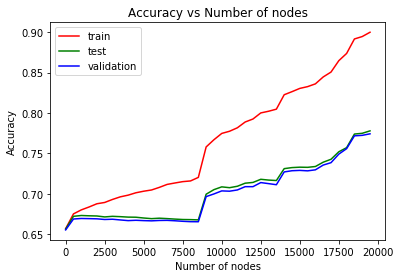

In [14]:
# Plotting the accuracies
plt.plot(count_arr, acc_train, label = "train", color='red')
plt.plot(count_arr, acc_test, label = "test", color='green')
plt.plot(count_arr, acc_val, label = "validation", color='blue')
plt.xlabel("Number of nodes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of nodes")
plt.legend()
plt.show()

### Part B

In [393]:
import copy

In [394]:
# Making a copy of the original tree
pruned_full_tree = copy.deepcopy(whole_tree)
remaining_size = total_count

In [395]:
# Get the size of the tree
def get_size(root: Node):
    
    if root is None:
        return 0
    elif root.type == NodeType.Leaf:
        return 1
    else:
        return 1 + get_size(root.right) + get_size(root.left)


In [396]:
# Global variables for post pruning stemp
maximum = get_accuracy(x_val, y_val, full_tree)
original = maximum
pruned_node = None
leaf_value = -1

# Post pruning starting tree with root
def post_pruning_step(root: Node, curr_node: Node, x, y, prediction):
    
    global maximum, x_val, y_val, original, pruned_node, leaf_value
    
    # Selecting the right partition
    x_new_r = np.array(x[x[:, curr_node.attribute_index] > curr_node.value, :])
    y_new_r = np.array(y[x[:, curr_node.attribute_index] > curr_node.value])
    pred_r = np.array(prediction[x[:, curr_node.attribute_index] > curr_node.value])
    
    # Selecting the left partition
    x_new_l = np.array(x[x[:, curr_node.attribute_index] <= curr_node.value, :])
    y_new_l = np.array(y[x[:, curr_node.attribute_index] <= curr_node.value])
    pred_l = np.array(prediction[x[:, curr_node.attribute_index] <= curr_node.value])
    
    # Removing left node 
    if curr_node.left is not None and curr_node.left.type != NodeType.Leaf and np.shape(y_new_l)[0] != 0:
        
        # Leaf prediction
        temp_data = np.bincount(y_new_l).argmax()
        
        # Check if accuracy increases
        pred_new = temp_data * np.ones_like(pred_l)
        count_change = np.sum(pred_new == y_new_l) - np.sum(pred_l == y_new_l)
        
        # The new accuracy
        accuracy = original + (count_change / np.shape(y_val)[0])
        
        # If accuracy increases
        if accuracy > maximum:
            maximum = accuracy
            pruned_node = curr_node.left
            leaf_value = temp_data
            
        
        # Continue pruning
        post_pruning_step(root, curr_node.left, x_new_l, y_new_l, pred_l)
        
    # Removing right node 
    if curr_node.right is not None and curr_node.right.type != NodeType.Leaf and np.shape(y_new_r)[0] != 0:
        
        # Leaf prediction
        temp_data = np.bincount(y_new_r).argmax()
         
        # Check if accuracy increases
        pred_new = temp_data * np.ones_like(pred_r)
        count_change = np.sum(pred_new == y_new_r) - np.sum(pred_r == y_new_r)
        
        # The new accuracy
        accuracy = original + (count_change / np.shape(y_val)[0])
        
        if accuracy > maximum:
            maximum = accuracy
            pruned_node = curr_node.right
            leaf_value = temp_data
        
        
        # Continue pruning
        post_pruning_step(root, curr_node.right, x_new_r, y_new_r, pred_r)
    
    return

In [397]:
# Assign values for global pruning values
def assign_global_pruning(x, y, root):
    
    global pruned_node, maximum, leaf_value, original
    
    # Assigning global variables for pruning
    maximum = get_accuracy(x, y, root)
    original = maximum
    pruned_node = None
    leaf_value = -1
    
    return

In [398]:
# Variables for plotting
acc_test = []
acc_train = []
acc_test = []
acc_val = []
count_arr = []
temp_count = 0

def post_pruning(root, x, y, x_test, y_test, x_train, y_train):
    
    global pruned_node, maximum, leaf_value, temp_count, original, remaining_size, acc_test, acc_train, acc_val, count_arr
    
    # Make a copy of the root    
    root_temp = copy.deepcopy(root)
        
    while True:
        
        # Assign global variables
        assign_global_pruning(x, y, root_temp)
        prediction = get_prediction(x, root_temp)
        
        # Data for plotting    
        acc_test.append(get_accuracy(x_test, y_test, root_temp))
        acc_train.append(get_accuracy(x_train, y_train, root_temp))
        acc_val.append(maximum)
        count_arr.append(remaining_size)
        print(temp_count, remaining_size, maximum)
        
        
        # Running for one step    
        post_pruning_step(root_temp, root_temp, x, y, prediction)
        if pruned_node is None:
            break
        
        temp_count += 1
        remaining_size -= (get_size(pruned_node) - 1)
        pruned_node.convert_to_leaf(leaf_value)
        

In [399]:
t0 = time()
post_pruning(pruned_full_tree, x_val, y_val, x_test, y_test, x_train, y_train)
print(time() - t0)

0 19977 0.7761913591692935
1 13385 0.7796680882625626
2 12179 0.7816614129427035
3 11539 0.7832838865195624
4 11089 0.7842110142777675
5 10625 0.7850454292601521
6 10079 0.7856944186908956
7 9983 0.7862970517337289
8 9929 0.7868069720007417
9 9773 0.7872705358798442
10 9151 0.7877340997589468
11 8881 0.788151307250139
12 8353 0.7885685147413314
13 8303 0.7889393658446134
14 8273 0.7893102169478954
15 8043 0.7896810680511774
16 7983 0.7900519191544595
17 7951 0.7903764138698313
18 7885 0.790700908585203
19 7647 0.7910254033005748
20 7487 0.7913498980159466
21 7453 0.7916280363434082
22 7359 0.7919061746708697
23 7301 0.7921843129983311
24 7255 0.7924160949378825
25 7245 0.7926478768774338
26 7241 0.792879658816985
27 7203 0.7931114407565363
28 7159 0.7933432226960875
29 7103 0.7935750046356388
30 7083 0.7937604301872798
31 7051 0.7939458557389208
32 7005 0.7941312812905619
33 6945 0.7943167068422029
34 6927 0.7945021323938438
35 6893 0.7946875579454848
36 6887 0.7948729834971259
37 6845

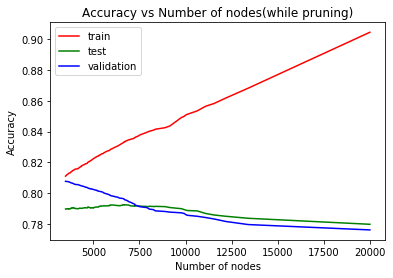

In [400]:
# Plotting the accuracies
plt.plot(count_arr, acc_train, label = "train", color='red')
plt.plot(count_arr, acc_test, label = "test", color='green')
plt.plot(count_arr, acc_val, label = "validation", color='blue')
plt.xlabel("Number of nodes")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Number of nodes(while pruning)")
plt.legend()
plt.show()

### Part C